In [2]:
%matplotlib inline 

import pandas as pd
import matplotlib.pyplot as plt

import json
import numpy as np
from datetime import datetime
from pytz import timezone

In [34]:
shoes_dir = './data/cloud_05-24-2017'

eastern = timezone('US/Eastern')
central = timezone('US/Central')

def convert2dt_sales(date, time) :
    if date and time :
        return eastern.localize(datetime.strptime(date + ' ' + time[:-4], "%A, %B %d, %Y %I:%M %p"))
    return None 

def convert2dt_timestamp(dt_str) :
    return central.localize(datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S.%f"))

tkr2shoe = {
    'YZY-1': 'adidas-yeezy-boost-350-v2-cream-white',
    'UB-1': 'adidas-ultra-boost-parley-night-navy',
    'NMD-1': 'adidas-nmd-core-black-lush-red',
    'NMDR1-1': 'adidas-nmd-r1-crisp-white',
    'NMDR1-2': 'adidas-nmd-r1-triple-black-reflective',
    'PHRL-1': 'adidas-tennis-hu-pharrell-white-green',
    'PHRL-2': 'adidas-tennis-hu-pharrell-white-yellow',
    'YZY-2': 'adidas-yeezy-boost-350-v2-steeple-grey-beluga-solar-red',
    'JRN1': 'air-jordan-1-retro-black-blue-2017',
    'JRN11': 'air-jordan-11-retro-low-university-blue',
    'JRN3': 'air-jordan-3-retro-true-blue-2016',
    'JRN4': 'air-jordan-4-retro-pure-money-2017',
    'JRN4-2': 'air-jordan-4-retro-royalty',
    'AMAX-1': 'nike-air-max-97-silver-bullet-2016',
    'AMAX-2': 'nike-air-more-uptempo-supreme-gold'}

cache_dfs = {}

def get_pricing(tkr, fields=None, sizes=None) :
    if tkr not in cache_dfs :
        shoe_name = tkr2shoe[tkr]
        with open('{}/{}.json'.format(shoes_dir, shoe_name)) as f :
            shoe_data = json.load(f)

        flat_sales = {'price': [], 'size': [], 'timestamp': []}
        for bar in shoe_data['history'] :
            for sale in bar['sales'] :
                flat_sales['price'].append(int(sale['price'][1:]))
                flat_sales['size'].append(float(sale['size']))
                flat_sales['timestamp'].append(convert2dt_sales(sale['date'], sale['time']))

        sales_df = pd.DataFrame(flat_sales)
        cache_dfs[tkr] = sales_df
    
    sales_df = cache_dfs[tkr].set_index('timestamp')
    
    if sizes :
        sales_df = sales_df[sales_df['size'].isin(sizes)]
    if fields :
        sales_df = sales_df[fields]
    
    return sales_df 

def get_bidask(tkr) :
    shoe_name = tkr2shoe[tkr]
    with open('{}/{}.json'.format(shoes_dir, shoe_name)) as f :
        shoe_data = json.load(f)
        
    flat_bids = {'price': [], 'size': [], 'timestamp': [], 'avail': []}
    flat_asks = {'price': [], 'size': [], 'timestamp': [], 'avail': []}
    for bar in shoe_data['history'] :
        timestamp = convert2dt_timestamp(bar['timestamp'])

        bar_bids = {'price': [], 'size': [], 'avail': []}
        for bid in bar['bids'] :
            flat_bids['price'].append(bid['price'])
            flat_bids['size'].append(bid['size'])
            flat_bids['avail'].append(bid['avail'])
            flat_bids['timestamp'].append(timestamp)

        for ask in bar['asks'] :
            flat_asks['price'].append(ask['price'])
            flat_asks['size'].append(ask['size'])
            flat_asks['avail'].append(ask['avail'])
            flat_asks['timestamp'].append(timestamp)
            
    bids_pd = pd.DataFrame(flat_bids)
    asks_pd = pd.DataFrame(flat_asks)

In [116]:
def reject_outliers(data, args, m=2):
    idx = abs(data - np.mean(data)) < m * np.std(data)

    if len(args) > 0 :
        mod_args = []
        for arg in args :
            mod_args.append(arg[idx])
        return [data[idx]] + mod_args
    return data[idx]

sales_history_cut, datetime_index_cut = reject_outliers(np.array(sales_history), [np.array(datetime_index)])
sales_history = pd.Series(sales_history_cut, index=datetime_index_cut)

In [44]:
sales_pd = get_pricing('YZY-1', fields=['price'], sizes=[9, 9.5, 10, 10.5, 11])

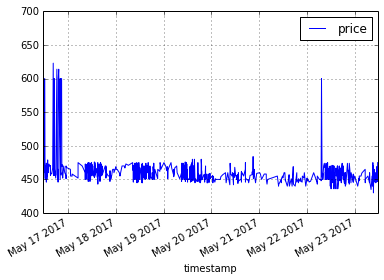

In [45]:
sales_pd.plot()